# Fantastic GPTs and Where to Find Them

Let's start by learning about GPT here:
https://jalammar.github.io/illustrated-gpt2/

(to learn about transformers, check out this: https://jalammar.github.io/illustrated-transformer/)

Some relevant content:

- History of GPT: https://finbarr.ca/five-years-of-gpt-progress/
- DataBricks just released a new **[OpenSource LLM, Free Dolly](https://www.databricks.com/blog/2023/04/12/dolly-first-open-commercially-viable-instruction-tuned-llm)**
  - https://github.com/databrickslabs/dolly
- Chip Huyen (Stanford) has a new post: [Building LLM applications for production](https://huyenchip.com/2023/04/11/llm-engineering.html)

<br><br><br><br><br>

**Reminder for SEI surveys**

https://seoi.ubc.ca/surveys

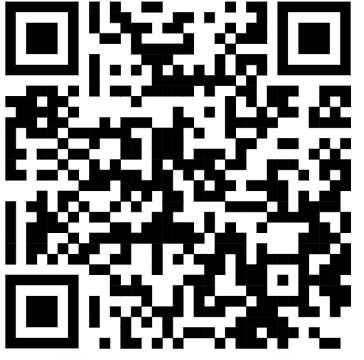

<br><br><br><br><br>

## GPT Implementation
Today, we will depend on the following two repositories (implemented by the same author), which have a simple implementation of GPT.

- https://github.com/karpathy/nanoGPT
- https://github.com/karpathy/minGPT

<br><br><br><br><br><br>
## Toy Demo (thanks to MiniGPT repo)
Let's continue with this small "Sorting Demo" with GPT
<br><br>

In [2]:
import sys
sys.path.append("mingpt")

In [3]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.utils import set_seed
set_seed(3407)

In [4]:
import pickle

class SortDataset(Dataset):
    """ 
    Dataset for the Sort problem. E.g. for problem length 6:
    Input: 0 0 2 1 0 1 -> Output: 0 0 0 1 1 2
    Which will feed into the transformer concatenated as:
    input:  0 0 2 1 0 1 0 0 0 1 1
    output: I I I I I 0 0 0 1 1 2
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=6, num_digits=3):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
        self.num_digits = num_digits
    
    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return self.num_digits
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return self.length * 2 - 1

    def __getitem__(self, idx):
        
        # use rejection sampling to generate an input example from the desired split
        while True:
            # generate some random integers
            inp = torch.randint(self.num_digits, size=(self.length,), dtype=torch.long)
            # half of the time let's try to boost the number of examples that 
            # have a large number of repeats, as this is what the model seems to struggle
            # with later in training, and they are kind of rate
            if torch.rand(1).item() < 0.5:
                if inp.unique().nelement() > self.length // 2:
                    # too many unqiue digits, re-sample
                    continue
            # figure out if this generated example is train or test based on its hash
            h = hash(pickle.dumps(inp.tolist()))
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok
        
        # solve the task: i.e. sort
        sol = torch.sort(inp)[0]

        # concatenate the problem specification and the solution
        cat = torch.cat((inp, sol), dim=0)

        # the inputs to the transformer will be the offset sequence
        x = cat[:-1].clone()
        y = cat[1:].clone()
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:self.length-1] = -1
        return x, y


In [8]:
# print an example instance of the dataset
train_dataset = SortDataset('train')
test_dataset = SortDataset('test')
x, y = train_dataset[0]
for a, b in zip(x,y):
    print(a, b)

tensor(2) tensor(-1)
tensor(0) tensor(-1)
tensor(0) tensor(-1)
tensor(1) tensor(-1)
tensor(1) tensor(-1)
tensor(2) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(1)
tensor(1) tensor(1)
tensor(1) tensor(2)
tensor(2) tensor(2)


In [13]:
# create a GPT instance
from mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model = GPT(model_config)

number of parameters: 0.09M


In [14]:
model_config.__dict__

{'model_type': 'gpt-nano',
 'n_layer': 3,
 'n_head': 3,
 'n_embd': 48,
 'vocab_size': 3,
 'block_size': 11,
 'embd_pdrop': 0.1,
 'resid_pdrop': 0.1,
 'attn_pdrop': 0.1}

In [15]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 2000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_dataset)

running on device cpu


In [16]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

iter_dt 0.00ms; iter 0: train loss 1.08078
iter_dt 20.73ms; iter 100: train loss 0.15526
iter_dt 25.15ms; iter 200: train loss 0.05155
iter_dt 16.79ms; iter 300: train loss 0.02887
iter_dt 20.12ms; iter 400: train loss 0.02557
iter_dt 30.11ms; iter 500: train loss 0.13786
iter_dt 18.16ms; iter 600: train loss 0.01904
iter_dt 21.56ms; iter 700: train loss 0.03605
iter_dt 24.39ms; iter 800: train loss 0.08329
iter_dt 16.91ms; iter 900: train loss 0.00272
iter_dt 16.60ms; iter 1000: train loss 0.03381
iter_dt 19.87ms; iter 1100: train loss 0.01317
iter_dt 20.47ms; iter 1200: train loss 0.00040
iter_dt 25.30ms; iter 1300: train loss 0.01219
iter_dt 22.60ms; iter 1400: train loss 0.00589
iter_dt 24.69ms; iter 1500: train loss 0.02379
iter_dt 21.75ms; iter 1600: train loss 0.00621
iter_dt 17.51ms; iter 1700: train loss 0.00209
iter_dt 18.68ms; iter 1800: train loss 0.01644
iter_dt 16.92ms; iter 1900: train loss 0.02377


In [17]:
# now let's perform some evaluation
model.eval();

In [18]:
def eval_split(trainer, split, max_batches):
    dataset = {'train':train_dataset, 'test':test_dataset}[split]
    n = train_dataset.length # naugy direct access shrug
    results = []
    mistakes_printed_already = 0
    loader = DataLoader(dataset, batch_size=100, num_workers=0, drop_last=False)
    for b, (x, y) in enumerate(loader):
        x = x.to(trainer.device)
        y = y.to(trainer.device)
        # isolate the input pattern alone
        inp = x[:, :n]
        sol = y[:, -n:]
        # let the model sample the rest of the sequence
        cat = model.generate(inp, n, do_sample=False) # using greedy argmax, not sampling
        sol_candidate = cat[:, n:] # isolate the filled in sequence
        # compare the predicted sequence to the true sequence
        correct = (sol == sol_candidate).all(1).cpu() # Software 1.0 vs. Software 2.0 fight RIGHT on this line haha
        for i in range(x.size(0)):
            results.append(int(correct[i]))
            if not correct[i] and mistakes_printed_already < 3: # only print up to 5 mistakes to get a sense
                mistakes_printed_already += 1
                print("GPT claims that %s sorted is %s but gt is %s" % (inp[i].tolist(), sol_candidate[i].tolist(), sol[i].tolist()))
        if max_batches is not None and b+1 >= max_batches:
            break
    rt = torch.tensor(results, dtype=torch.float)
    print("%s final score: %d/%d = %.2f%% correct" % (split, rt.sum(), len(results), 100*rt.mean()))
    return rt.sum()

# run a lot of examples from both train and test through the model and verify the output correctness
with torch.no_grad():
    train_score = eval_split(trainer, 'train', max_batches=50)
    test_score  = eval_split(trainer, 'test',  max_batches=50)

train final score: 5000/5000 = 100.00% correct
test final score: 5000/5000 = 100.00% correct


In [19]:
# let's run a random given sequence through the model as well
n = train_dataset.length # naugy direct access shrug
inp = torch.tensor([[0, 0, 2, 1, 0, 1]], dtype=torch.long).to(trainer.device)
assert inp[0].nelement() == n
with torch.no_grad():
    cat = model.generate(inp, n, do_sample=False)
sol = torch.sort(inp[0])[0]
sol_candidate = cat[:, n:]
print('input sequence  :', inp.tolist())
print('predicted sorted:', sol_candidate.tolist())
print('gt sort         :', sol.tolist())
print('matches         :', bool((sol == sol_candidate).all()))

input sequence  : [[0, 0, 2, 1, 0, 1]]
predicted sorted: [[0, 0, 0, 1, 1, 2]]
gt sort         : [0, 0, 0, 1, 1, 2]
matches         : True


<br><br><br><br>
## Shakespere Demo (Thanks to NanoGPT repo)

### Steps to Train and Sample from GPT

We will train a very small GPT model today.

**New Libraries to be installed**
I have created `requirements.txt` file (`lectures/AmirAbdi/gpt/requirements.txt`) which you can use to install dependencies in a new environment

Run the following in terminal:

```bash
conda create -n nanogpt python=3.10
conda activate nanogpt
pip install -r requirements.txt
```

Now, clone the NanoGPT repository:
```bash
git clone https://github.com/karpathy/nanoGPT
```

Then, to start training a simple model on Shakespeare data, run the following:


```bash
# Prepare the data
python data/shakespeare_char/prepare.py

# Train the model
python train.py \
    config/train_shakespeare_char.py \
    --device=cpu \
    --compile=False \
    --eval_iters=20 \
    --log_interval=1 \
    --block_size=64 \
    --batch_size=12 \
    --n_layer=4 \
    --n_head=4 \
    --n_embd=128 \
    --max_iters=1000 \
    --lr_decay_iters=2000 \
    --dropout=0.0
```

It will take a while to finish (on my laptop, training on CPU, it took 40 minutes)

Now you can start generating new Shakespeare plays by calling

```bash
python sample.py --out_dir=out-shakespeare-char
```